In [2]:
import numpy as np
import sys
sys.path.append("../../src/")
import utility
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_chisquare

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import statsmodels.api as sm

from scipy import stats

import pandas as pd

import math


In [12]:
df_IEA_P1 = pd.read_csv("../../output/IEA_P1.csv").set_index("sid")
df_data = utility.load_data()


df_used = pd.merge(df_IEA_P1, df_data, left_index = True, right_index = True)



/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

# Regression with Both IEAs and FAs

In [14]:
independents = ["IEA0", "IEA1", "PCA_emphysema_axis", "PCA_airway_axis"]

dependents = ['FEV1pp_utah_P1', 'FEV1_FVC_utah_P1', 'SGRQ_scoreTotal_P1', "MMRCDyspneaScor_P1", 'distwalked_P1',
           'delta_FEV1pp_P1P2', "delta_FEV1FVC_P1P2",
           ]

models_IEA = []
cov_dict_IEA = {iii:[] for iii in independents}

In [15]:
for ccc in dependents:
    X = df_used[independents]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx].astype(float)
    
    X = sm.add_constant(X.apply(stats.zscore))
    y = stats.zscore(y)
    
    
    M_OLS = sm.OLS(y, X).fit()

    models_IEA.append(M_OLS)

    
    v = M_OLS.summary2().tables[1].values
    
    
    for iii in range(1, len(independents) + 1):
        col = independents[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict_IEA[col].append(eee + "\n" + CI1)

# Base Regression with FAs only

In [33]:
independents = ["PCA_emphysema_axis", "PCA_airway_axis"
]

dependents = ['FEV1pp_utah_P1', 'FEV1_FVC_utah_P1', 'SGRQ_scoreTotal_P1', "MMRCDyspneaScor_P1", 'distwalked_P1',
           'delta_FEV1pp_P1P2', "delta_FEV1FVC_P1P2",
           ]

models_FA = []
cov_dict_FA = {iii:[] for iii in independents}

In [34]:
for ccc in dependents:
    X = df_used[independents]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx].astype(float)
    
    X = sm.add_constant(X.apply(stats.zscore))
    y = stats.zscore(y)
    
    
    M_OLS = sm.OLS(y, X).fit()

    models_FA.append(M_OLS)

    
    v = M_OLS.summary2().tables[1].values
    
    
    for iii in range(1, len(independents) + 1):
        col = independents[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict_FA[col].append(eee + "\n" + CI1)

# Computing p-values for likelihood ratio test

In [35]:

from scipy.stats.distributions import chi2


p_values = []

for iii in range(len(models_IEA)):
    model_null = models_FA[iii]
    model_alt = models_IEA[iii]
    
    ll_null = model_null.llf
    ll_alt = model_alt.llf
    dg_null = model_null.df_model
    dg_alt = model_alt.df_model
    
    chi2_stat = -2 * (ll_null-ll_alt)
    p = chi2.sf(chi2_stat, dg_alt-dg_null)
    
    p_values.append( p )

p_values_str = []
for iii in p_values:
    if iii < .001:
        p_values_str.append("<.001")
    else:
        p_values_str.append("{:.3f}".format(iii))
    
p_values = np.array(p_values)[:, None]
p_values_str = np.array(p_values_str)[:, None]

In [36]:
rows = ["FEV$_1$ %predicted", "FEV$_1$ / FVC", "SGRQ Total Score", "MMRC Dyspnea Score", "6-Minute-Walk Distance", 
        "$\Delta$FEV$_1$ %predicted", "$\Delta$FEV$_1$/FVC"
       ]


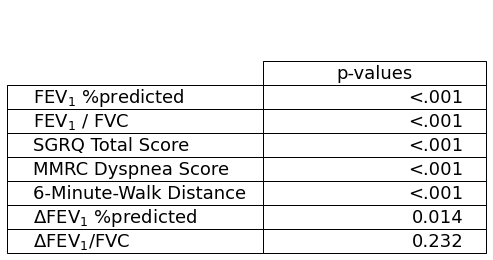

In [37]:
fig, ax = plt.subplots(figsize=(2,1))

the_table=plt.table(cellText = p_values_str, rowLabels = rows, 
                    colLabels = ["p-values"])

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

# Table for beta coeffcients ( FAs  )

In [40]:
independents = ["PCA_emphysema_axis", "PCA_airway_axis"]

cov_label = ["FA$_{emph}$", "FA$_{airway}$"]

In [42]:
table = np.array( [ [cov_dict_FA[ccc][iii] for ccc in independents] for iii in range(len(models_FA))  ] )

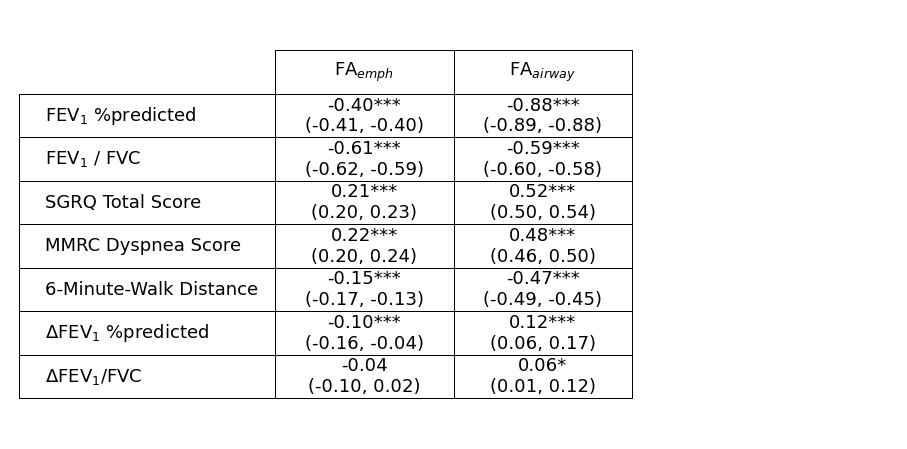

In [44]:
fig, ax = plt.subplots(figsize=(16,8))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    

# Table for beta coeffcients ( FAs + IEAs  )

In [45]:
independents = ["IEA0", "IEA1", "PCA_emphysema_axis", "PCA_airway_axis"]

cov_label = [ "IEA$_{emph}$", "IEA$_{airway}$", "FA$_{emph}$", "FA$_{airway}$"]

In [47]:
table = np.array( [ [cov_dict_IEA[ccc][iii] for ccc in independents] for iii in range(len(models_IEA))  ] )

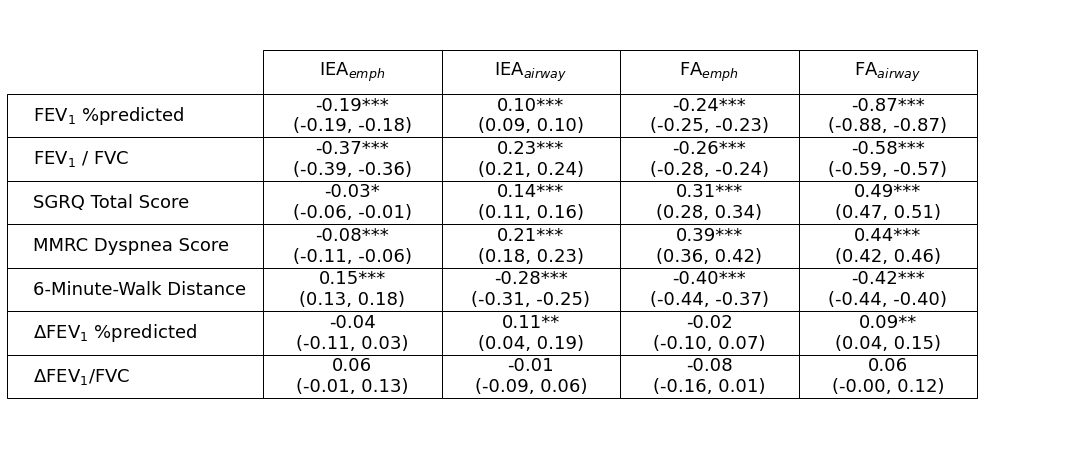

In [48]:
fig, ax = plt.subplots(figsize=(16,8))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    